# Segmentation Basics: Thresholding, Watershed, and Template Matching
This notebook demonstrates three common segmentation techniques using scikit-image:
- Global and local thresholding (Otsu, Yen, Sauvola)
- Watershed segmentation using distance transform and markers
- Template matching via normalized cross-correlation

Datasets used: `skimage.data.coins()` for thresholding and watershed, and `skimage.data.camera()` for template matching.

<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_03/code_examples/example_05_segmentation.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Run this notebook in Colab if your local environment is missing dependencies.

In [1]:
# Setup: install dependencies in Colab and import libraries
import sys, subprocess, warnings

def _install_packages():
    try:
        subprocess.run([sys.executable, '-m', 'pip', 'install', '-q',
                        'scikit-image', 'matplotlib', 'numpy', 'scipy'], check=False)
    except Exception as e:
        print(f'Package install skipped or failed: {e}')

if 'google.colab' in sys.modules:
    _install_packages()

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, filters, morphology, measure, segmentation, feature, util, exposure
from scipy import ndimage as ndi

warnings.filterwarnings('ignore')
np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['image.cmap'] = 'gray'
print('Environment ready.')

Environment ready.


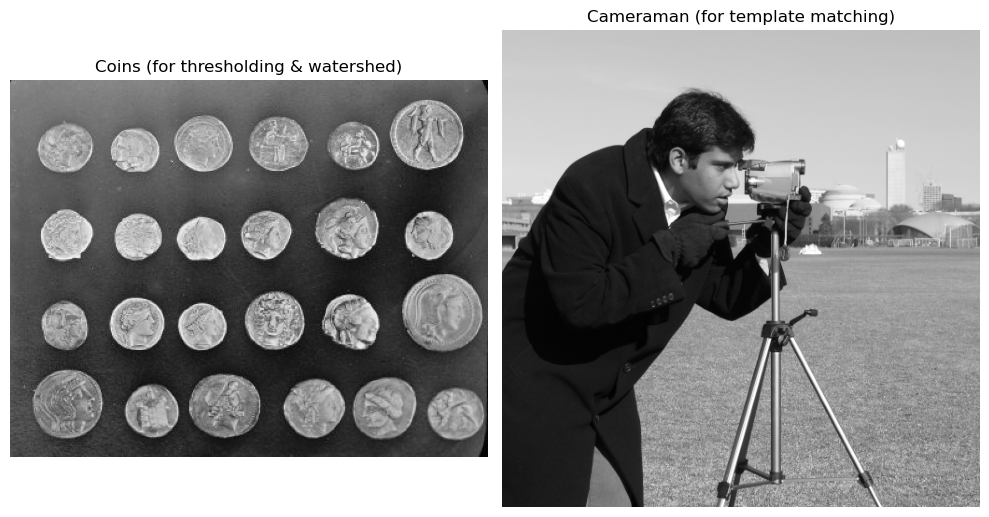

In [2]:
# Load example images
coins = data.coins()  # grayscale uint8 image
camera = data.camera()  # grayscale uint8 image

fig, axes = plt.subplots(1, 2)
axes[0].imshow(coins)
axes[0].set_title('Coins (for thresholding & watershed)')
axes[0].axis('off')
axes[1].imshow(camera)
axes[1].set_title('Cameraman (for template matching)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

## Thresholding
We compare several thresholding methods to binarize the `coins` image:
- Otsu's method (global)
- Yen's method (global)
- Sauvola local threshold (adaptive)
We also apply simple morphological clean-up (remove small objects, fill holes).

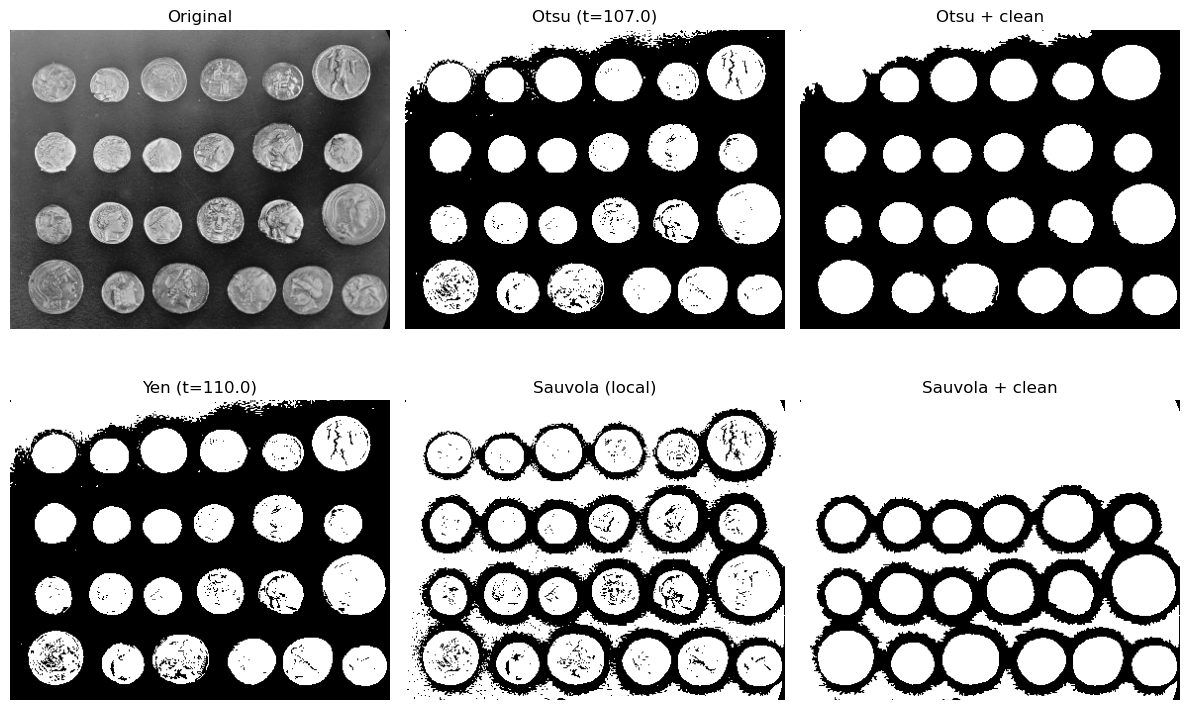

Estimated coin count (connected components) with Otsu+clean: 24
Estimated coin count with Sauvola+clean: 21


In [3]:
# Global thresholds: Otsu and Yen
otsu_t = filters.threshold_otsu(coins)
yen_t = filters.threshold_yen(coins)
binary_otsu = coins > otsu_t
binary_yen = coins > yen_t

# Local (adaptive) threshold: Sauvola
sauvola_t = filters.threshold_sauvola(coins, window_size=25)
binary_sauvola = coins > sauvola_t

# Morphological clean-up
clean_otsu = morphology.remove_small_objects(binary_otsu, min_size=64)
clean_otsu = ndi.binary_fill_holes(clean_otsu)
clean_yen = morphology.remove_small_objects(binary_yen, min_size=64)
clean_yen = ndi.binary_fill_holes(clean_yen)
clean_sauvola = morphology.remove_small_objects(binary_sauvola, min_size=64)
clean_sauvola = ndi.binary_fill_holes(clean_sauvola)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes[0,0].imshow(coins)
axes[0,0].set_title('Original')
axes[0,0].axis('off')
axes[0,1].imshow(binary_otsu)
axes[0,1].set_title(f'Otsu (t={otsu_t:.1f})')
axes[0,1].axis('off')
axes[0,2].imshow(clean_otsu)
axes[0,2].set_title('Otsu + clean')
axes[0,2].axis('off')
axes[1,0].imshow(binary_yen)
axes[1,0].set_title(f'Yen (t={yen_t:.1f})')
axes[1,0].axis('off')
axes[1,1].imshow(binary_sauvola)
axes[1,1].set_title('Sauvola (local)')
axes[1,1].axis('off')
axes[1,2].imshow(clean_sauvola)
axes[1,2].set_title('Sauvola + clean')
axes[1,2].axis('off')
plt.tight_layout()
plt.show()

print('Estimated coin count (connected components) with Otsu+clean:', np.max(morphology.label(clean_otsu)))
print('Estimated coin count with Sauvola+clean:', np.max(morphology.label(clean_sauvola)))

## Watershed Segmentation
We segment individual coins using a marker-based watershed on the negative distance transform of a binary mask (separates touching objects).

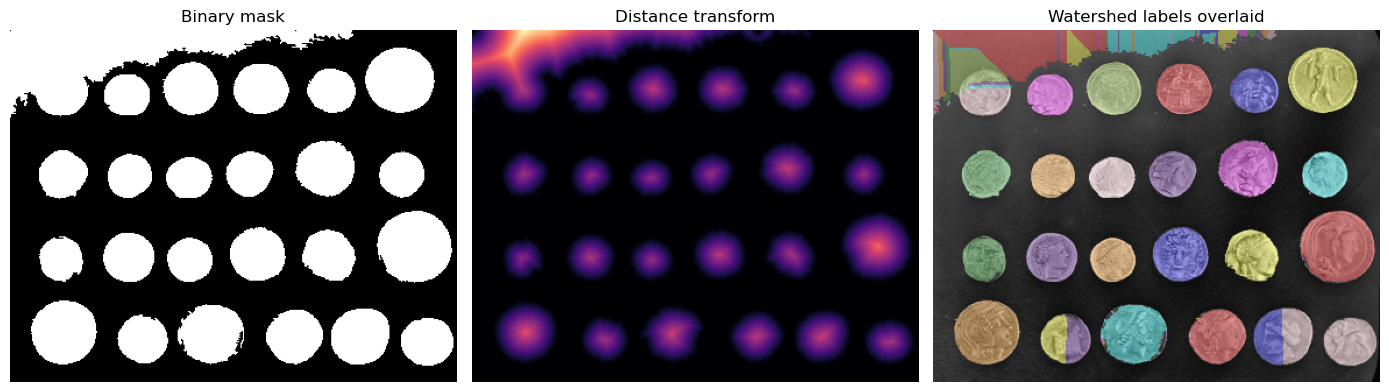

Separated objects (watershed labels): 111


In [7]:
# Start from a clean binary mask (Otsu + clean)
binary = clean_otsu
# Distance transform
distance = ndi.distance_transform_edt(binary)
# Find peaks to serve as markers (coords -> boolean mask)
coords = feature.peak_local_max(distance, footprint=np.ones((3, 3)), labels=binary)
local_maxi = np.zeros_like(distance, dtype=bool)
if coords.size > 0:
    local_maxi[tuple(coords.T)] = True
markers = ndi.label(local_maxi)[0]
# Watershed on the negative distance (so peaks become basins)
labels_ws = segmentation.watershed(-distance, markers, mask=binary)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(binary)
axes[0].set_title('Binary mask')
axes[0].axis('off')
axes[1].imshow(distance, cmap='magma')
axes[1].set_title('Distance transform')
axes[1].axis('off')
axes[2].imshow(color.label2rgb(labels_ws, image=coins, bg_label=0))
axes[2].set_title('Watershed labels overlaid')
axes[2].axis('off')
plt.tight_layout()
plt.show()

print('Separated objects (watershed labels):', labels_ws.max())

## Template Matching
We locate a specific pattern in the `camera` image using normalized cross-correlation via `skimage.feature.match_template`.

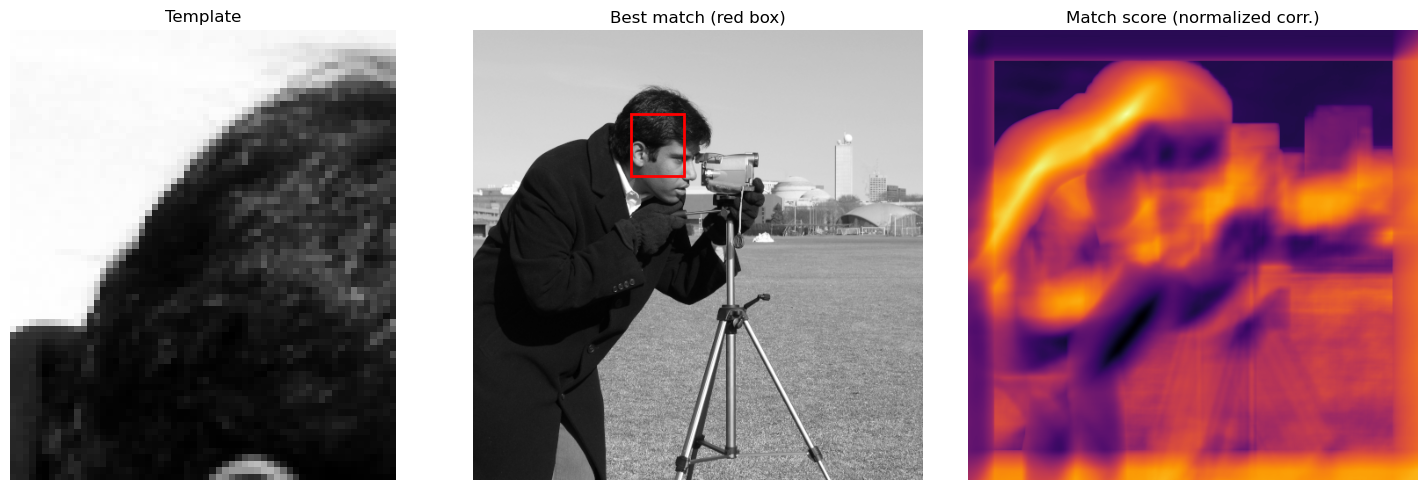

Max correlation score: 1.000 at location (x=180, y=95)


In [6]:
# Define a template by cropping a region (face area)
# Adjust indices if desired to target a different region
template = camera[60:130, 150:210]

result = feature.match_template(camera, template, pad_input=True)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]
score = result.max()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(template)
axes[0].set_title('Template')
axes[0].axis('off')
axes[1].imshow(camera)
axes[1].add_patch(plt.Rectangle((x, y), template.shape[1], template.shape[0],
                                    edgecolor='r', facecolor='none', linewidth=2))
axes[1].set_title('Best match (red box)')
axes[1].axis('off')
axes[2].imshow(result, cmap='inferno')
axes[2].set_title('Match score (normalized corr.)')
axes[2].axis('off')
plt.tight_layout()
plt.show()

print(f'Max correlation score: {score:.3f} at location (x={x}, y={y})')

### Notes
- Thresholding is fast and effective when foreground/background are separable.
- Watershed helps split touching objects using shape cues via the distance transform.
- Template matching is best for locating known patterns; results depend on template quality and scale.

Try adjusting parameters (e.g., Sauvola window size, footprint for peak detection, template region) to see how results change.